# On particle filters applied to electricity load forecasting

PyMC tuto

https://pymc-devs.github.io/pymc/tutorial.html#fitting-the-model-with-mcmc

http://sdsawtelle.github.io/blog/output/mcmc-in-python-with-pymc.html
    

NC Email:

Voilà quelques pistes que vous pouvez suivre:
* commencer par implémenter un bootstrap filter pour le modèle proposé, et des valeurs des paramètres choisis à la main ﴾en fonction des valeurs reportées dans l'article par exemple﴿ et des données que vous pouvez simuler. Déterminer à quel point l'algorithme marche bien:
+ graphe de l'ESS en fonction du temps; voir si effectivement certains outliers font fortement chuter l'ESS. Essayer la méthode proposée pour gérer ses outliers.
+ intervalles de confiance pour l'estimation de E[X_t|Y_{0:t}], basé sur plusieurs exécutions, par exemple.

Deuxième étape: estimation des paramètres. Vous pouvez essayer une des trois approches suivantes, triées par ordre de difficulté:
1. maximisation de la vraisemblance ﴾estimée par votre filtre particulaire pour un theta donné﴿, en utilisant une méthode de maximisation pour fonction bruitée ﴾par ex Robbins‐Monroe﴿.
2. PMMH, voir le prochain cours. Principale difficulté: l'algorithme peut prendre du temps, et ne pas être très facile à calibrer, mais je vais en parler en cours.
3. Particle Gibbs: c'est peut‐être un peu compliqué pour ce modèle, mais si vous arrivez, gros bonus!

In [1]:
import pandas as pd
import numpy as np
import numpy.random as npr
import matplotlib as mtp
import matplotlib.pyplot as plt
import scipy as sp
from scipy.stats import truncnorm
import scipy.stats as stats
from scipy.stats import invgamma
from scipy import ndimage
import math

In [2]:
%load_ext autoreload
%autoreload 2
from elec_forecast.bootstrap_filter_model import BootstrapFilterModel
from elec_forecast.rm_estimation import RmEstimation
from elec_forecast.particle_filter import ParticleFilter

### Parameters

In [24]:
M=10**3 #number of particles
n_pred=715  #number of predictions
N_daytype=8  #number of day types

### Load temperatures data 2015-2016

In [4]:
df_temp=pd.read_csv('data/temp_1516.csv',sep=',')
df_temp=df_temp.drop(df_temp.columns[0],axis=1)
df_temp=df_temp.sort_values(by='date')
df_temp.head()

,date,hour,t
0,2015-01-01,00:00,5.057414
1,2015-01-01,03:00,4.609138
2,2015-01-01,06:00,4.729828
3,2015-01-01,09:00,6.052241
4,2015-01-01,12:00,9.347069


In [5]:
#temperatures every day at 3pm
temp_day=df_temp[df_temp.hour=="15:00"]
temp_day.head()
#Array vector of temperatures for each day of the year
T_h=list(temp_day.t)

### Load electricity data

In [6]:
mypath="data/"
df=pd.read_csv(mypath+"cdc_conso_daytypes.csv",sep=",",encoding='latin-1')
df=df.drop(["daytype"+str(i) for i in range(0,9)],axis=1)
df=df.drop(df.columns[0],axis=1)
df.index=range(0,len(df))
df=df.sort_values(by=['Date'])
df['Date - Heure']=pd.to_datetime(df['Date - Heure'])
df.sort_values(by=["Date - Heure"])
#truncate to the data from 2015
df=df[(df.Date >='2015-01-01')]
df.head()

,Date - Heure,Date,Heure,Consommation (MW),Qualite donnee,daytype
166957,2015-01-01 03:30:00,2015-01-01,04:30,64838,DÃ©finitive,6
153294,2015-01-01 18:30:00,2015-01-01,19:30,72562,DÃ©finitive,6
153293,2015-01-01 18:00:00,2015-01-01,19:00,71766,DÃ©finitive,6
152017,2015-01-01 01:00:00,2015-01-01,02:00,71134,DÃ©finitive,6
152018,2015-01-01 04:30:00,2015-01-01,05:30,64379,DÃ©finitive,6


### Set variables of electricity demand

In [7]:
from datetime import date
df['Consommation']=df['Consommation (MW)']   #leave it in MW
#For prediction, every day at 3pm
consumption_day_ahead = list(df[df['Heure']=='15:00']['Consommation'])
#for initialization
consumption = list(df[df['Heure']=='15:00']['Consommation'][:30])

### Daytype

In [8]:
daytype=np.array(df.daytype)

## Implementation of Algorithm 3.10

## At time n=0:

### 1.Definition of MCMC initial model at n=0 - sample $X_0^{j} \sim \mu(x_0)$

### Option C: MCMC using MHA or Gibbs (TBA)

#### Freeze parameters from Zak's simulation in gibbs-parameters_init_v1

In [9]:
N_daytype=9
k_day=npr.dirichlet(np.ones(N_daytype),1)
len_init=15
pred_forward=[0]

In [10]:
#Load pickle file
import pickle
output_file ='data/parameters_init_20180113-135329.pkl'
pkl_file = open(output_file, 'rb')
parameters_init = pickle.load(pkl_file)
parameters_init

{'g_heat_init': array([-814623.94530988,   -1103.5042025 ,  -13509.35223552,
         -12839.18874712,  -13810.69394068,  -13621.95767042,
         -16305.45122647,  -16251.90232773,  -16229.3696953 ,
         -17229.49394215,  -13669.17597616,  -15726.25635544,
         -14808.97478176,  -14519.69267177,  -13655.86349596,
         -13546.63330023,  -13762.6351832 ,  -16223.92473751,
         -16231.78960435,  -17198.22294889,  -16084.04185055,
         -14859.33888566,  -15086.97652322,  -15659.32736924,
         -15025.21396291,  -16876.95500528,  -18016.91503558,
         -14386.93382501,  -14456.1228341 ,  -17258.13559834,
         -16399.27181928,  -14184.38234493,  -17037.65684651,
         -17577.66776037,  -15905.47860891,  -14955.89959227,
         -16811.49451007,  -15179.88058645,  -16273.87576028,
         -16666.00910714,  -16425.26301396,  -17107.27359641,
         -17374.00623292,  -13665.90412278,  -16588.1106145 ,
         -16457.00065552,  -16112.43401709,  -15547.969

In [11]:
s_init=parameters_init['s_init']
g_heat_init=parameters_init['g_heat_init']
sigma_s_init=parameters_init['sigma_s_init']
sigma_g_init=parameters_init['sigma_g_init']
x_init=parameters_init['x_init']
sigma2=parameters_init['sigma2']
u_h=parameters_init['u_h']
kappa=parameters_init['kappa']
w_init=parameters_init['w_init']

In [12]:
sigma2=np.ones(M)*3*10**7
sigma_g_init=np.ones(M)*10**4
sigma_s_init=np.ones(M)*10**4
kappa=np.ones(M)*1/9

In [13]:
w_init[0]=np.median(w_init)
x_init[0]=np.median(x_init)
g_heat_init[0]=np.median(g_heat_init)
s_init[0]=np.median(s_init)

### Part 2: regularize weights and x if necessary

In [14]:
pf = ParticleFilter(consumption_day_ahead, 
                    T_h, 
                    daytype, 
                    n_pred, 
                    M, 
                    x_init, 
                    w_init,
                    kappa,
                    u_h, 
                    sigma_s_init, 
                    sigma_g_init, 
                    s_init, 
                    g_heat_init, 
                    sigma2)

ESS of normalized weights= 862.234232
ESS>=0.5*M
new ESS= 862.234232


## Prediction and Filtering at time n>0

### 1. Sample $x^j_n \mid X^j_{n-1} $ for all j=1...M particles

In [25]:
x_predict, ESS_calc = pf.predict(pred_forward, n_pred, len_init)

n= 1
mean s: 1.37e+04
x_pred_mean = 3.90e+04 real consumption= 6.86e+04
x_pred min= 9.99e+02 x_pred max 2.04e+05
ESS of normalized weights= 107.148691
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 2
mean s: 2.10e+04
x_pred_mean = 6.56e+04 real consumption= 6.41e+04
x_pred min= 6.24e+02 x_pred max 4.27e+05
ESS of normalized weights= 142.941905
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 3
mean s: 2.86e+04
x_pred_mean = 1.01e+05 real consumption= 5.74e+04
x_pred min= 1.89e+03 x_pred max 5.05e+05
ESS of normalized weights= 109.047672
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 4
mean s: 3.68e+04
x_pred_mean = 1.30e+05 real consumption= 7.31e+04
x_pred min= 4.08e+02 x_pred max 5.68e+05
ESS of normalized weights= 98.893344
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 5
mean s: 4.39e+04
x_pred_mean = 1.35e+05 real consumption= 7.68e+04
x_pred min= 2.22e+03 x_pred max 5.81e+05
ESS 

new ESS= 1000.0
------------------------
n= 38
mean s: 2.93e+05
No heating effect
x_pred_mean = 3.25e+04 real consumption= 6.70e+04
x_pred min= 3.65e+01 x_pred max 1.33e+05
ESS of normalized weights= 80.213253
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 39
mean s: 3.03e+05
x_pred_mean = 1.75e+05 real consumption= 7.57e+04
x_pred min= 6.35e+03 x_pred max 7.00e+05
ESS of normalized weights= 75.137839
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 40
mean s: 3.17e+05
No heating effect
x_pred_mean = 3.52e+04 real consumption= 7.55e+04
x_pred min= 3.81e+01 x_pred max 1.33e+05
ESS of normalized weights= 105.090177
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 41
mean s: 3.35e+05
No heating effect
x_pred_mean = 3.72e+04 real consumption= 7.16e+04
x_pred min= 7.43e+01 x_pred max 1.55e+05
ESS of normalized weights= 109.040785
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 42
mean s: 3.49e

x_pred_mean = 8.76e+04 real consumption= 5.60e+04
x_pred min= 2.70e+01 x_pred max 3.13e+05
ESS of normalized weights= 141.825719
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 74
mean s: 8.02e+05
No heating effect
x_pred_mean = 8.91e+04 real consumption= 6.36e+04
x_pred min= 1.05e+03 x_pred max 3.38e+05
ESS of normalized weights= 144.907622
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 75
mean s: 8.09e+05
No heating effect
x_pred_mean = 8.99e+04 real consumption= 6.06e+04
x_pred min= 8.01e+00 x_pred max 3.31e+05
ESS of normalized weights= 138.630786
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 76
mean s: 8.11e+05
No heating effect
x_pred_mean = 9.01e+04 real consumption= 5.89e+04
x_pred min= 4.82e+02 x_pred max 3.23e+05
ESS of normalized weights= 137.436267
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 77
mean s: 8.14e+05
No heating effect
x_pred_mean = 9.04e+04 real consumption=

new ESS= 1000.0
------------------------
n= 110
mean s: 1.04e+06
No heating effect
x_pred_mean = 1.15e+05 real consumption= 5.22e+04
x_pred min= 6.94e+00 x_pred max 4.20e+05
ESS of normalized weights= 106.536657
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 111
mean s: 1.04e+06
No heating effect
x_pred_mean = 1.16e+05 real consumption= 5.20e+04
x_pred min= 1.90e+02 x_pred max 4.05e+05
ESS of normalized weights= 114.703903
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 112
mean s: 1.05e+06
No heating effect
x_pred_mean = 1.17e+05 real consumption= 5.22e+04
x_pred min= 2.37e+02 x_pred max 4.16e+05
ESS of normalized weights= 117.65936
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 113
mean s: 1.07e+06
No heating effect
x_pred_mean = 1.19e+05 real consumption= 5.14e+04
x_pred min= 3.87e+01 x_pred max 4.14e+05
ESS of normalized weights= 106.072511
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
---------------------

new ESS= 1000.0
------------------------
n= 146
mean s: 1.40e+06
No heating effect
x_pred_mean = 1.55e+05 real consumption= 5.24e+04
x_pred min= 6.92e+02 x_pred max 6.85e+05
ESS of normalized weights= 69.407601
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 147
mean s: 1.41e+06
No heating effect
x_pred_mean = 1.57e+05 real consumption= 5.28e+04
x_pred min= 1.69e+02 x_pred max 6.66e+05
ESS of normalized weights= 76.533417
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 148
mean s: 1.43e+06
No heating effect
x_pred_mean = 1.59e+05 real consumption= 5.18e+04
x_pred min= 1.00e+02 x_pred max 6.68e+05
ESS of normalized weights= 77.354197
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 149
mean s: 1.44e+06
No heating effect
x_pred_mean = 1.60e+05 real consumption= 4.41e+04
x_pred min= 5.80e+00 x_pred max 6.83e+05
ESS of normalized weights= 68.290167
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------

new ESS= 1000.0
------------------------
n= 182
mean s: 1.75e+06
No heating effect
x_pred_mean = 1.95e+05 real consumption= 5.71e+04
x_pred min= 2.89e+02 x_pred max 8.74e+05
ESS of normalized weights= 66.279807
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 183
mean s: 1.76e+06
No heating effect
x_pred_mean = 1.96e+05 real consumption= 5.70e+04
x_pred min= 2.32e+01 x_pred max 8.86e+05
ESS of normalized weights= 51.479873
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 184
mean s: 1.77e+06
No heating effect
x_pred_mean = 1.96e+05 real consumption= 4.83e+04
x_pred min= 3.66e+02 x_pred max 8.70e+05
ESS of normalized weights= 55.890409
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 185
mean s: 1.78e+06
No heating effect
x_pred_mean = 1.98e+05 real consumption= 4.27e+04
x_pred min= 8.62e+02 x_pred max 8.87e+05
ESS of normalized weights= 67.718733
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------

mean s: 2.05e+06
No heating effect
x_pred_mean = 2.28e+05 real consumption= 4.93e+04
x_pred min= 1.77e+03 x_pred max 8.28e+05
ESS of normalized weights= 55.236664
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 217
mean s: 2.06e+06
No heating effect
x_pred_mean = 2.29e+05 real consumption= 4.99e+04
x_pred min= 5.21e-01 x_pred max 8.45e+05
ESS of normalized weights= 47.898167
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 218
mean s: 2.06e+06
No heating effect
x_pred_mean = 2.29e+05 real consumption= 4.95e+04
x_pred min= 9.47e+02 x_pred max 8.39e+05
ESS of normalized weights= 50.805405
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 219
mean s: 2.07e+06
No heating effect
x_pred_mean = 2.30e+05 real consumption= 4.25e+04
x_pred min= 5.06e+02 x_pred max 8.43e+05
ESS of normalized weights= 45.321779
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 220
mean s: 2.08e+06
No heating effect
x_pre

new ESS= 1000.0
------------------------
n= 252
mean s: 2.27e+06
No heating effect
x_pred_mean = 2.52e+05 real consumption= 5.23e+04
x_pred min= 1.24e+02 x_pred max 9.82e+05
ESS of normalized weights= 49.125067
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 253
mean s: 2.27e+06
No heating effect
x_pred_mean = 2.53e+05 real consumption= 5.14e+04
x_pred min= 9.68e+02 x_pred max 9.66e+05
ESS of normalized weights= 46.16735
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 254
mean s: 2.28e+06
No heating effect
x_pred_mean = 2.53e+05 real consumption= 4.41e+04
x_pred min= 8.18e+02 x_pred max 9.42e+05
ESS of normalized weights= 41.126446
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 255
mean s: 2.28e+06
No heating effect
x_pred_mean = 2.53e+05 real consumption= 4.03e+04
x_pred min= 4.57e+02 x_pred max 9.34e+05
ESS of normalized weights= 50.744212
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------


new ESS= 1000.0
------------------------
n= 289
mean s: 2.36e+06
No heating effect
x_pred_mean = 2.62e+05 real consumption= 5.27e+04
x_pred min= 6.28e+01 x_pred max 1.03e+06
ESS of normalized weights= 43.373576
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 290
mean s: 2.36e+06
No heating effect
x_pred_mean = 2.62e+05 real consumption= 4.87e+04
x_pred min= 2.38e+02 x_pred max 1.03e+06
ESS of normalized weights= 53.431342
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 291
mean s: 2.37e+06
No heating effect
x_pred_mean = 2.63e+05 real consumption= 5.92e+04
x_pred min= 4.30e+01 x_pred max 1.01e+06
ESS of normalized weights= 52.629817
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 292
mean s: 2.37e+06
No heating effect
x_pred_mean = 2.64e+05 real consumption= 5.99e+04
x_pred min= 4.17e+01 x_pred max 1.03e+06
ESS of normalized weights= 51.581929
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------

new ESS= 1000.0
------------------------
n= 329
mean s: 2.52e+06
No heating effect
x_pred_mean = 2.80e+05 real consumption= 6.73e+04
x_pred min= 5.37e+02 x_pred max 9.55e+05
ESS of normalized weights= 46.090954
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 330
mean s: 2.52e+06
No heating effect
x_pred_mean = 2.80e+05 real consumption= 6.82e+04
x_pred min= 2.21e+02 x_pred max 9.61e+05
ESS of normalized weights= 48.939046
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 331
mean s: 2.53e+06
x_pred_mean = 1.86e+06 real consumption= 6.04e+04
x_pred min= 8.16e+04 x_pred max 7.15e+06
ESS of normalized weights= 1.000013
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 332
mean s: 2.54e+06
x_pred_mean = 5.14e+05 real consumption= 5.67e+04
x_pred min= 3.36e+04 x_pred max 1.83e+06
ESS of normalized weights= 5.612476
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 333
mean s: 2.55e+06
No heating ef

/Users/antoinegrelety/Documents/smc_electricity_forecast/elec_forecast/particle_filter.py:60: RuntimeWarning: invalid value encountered in true_divide
  w_h = w_/sum(w_)


 1000.0
------------------------
n= 371
mean s: 2.94e+06
x_pred_mean = 5.25e+06 real consumption= 6.88e+04
x_pred min= 2.03e+04 x_pred max 2.04e+07
ESS of normalized weights= 1.989618
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 372
mean s: 2.94e+06
x_pred_mean = 1.02e+06 real consumption= 6.73e+04
x_pred min= 4.58e+04 x_pred max 3.39e+06
ESS of normalized weights= 1.009364
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 373
mean s: 2.94e+06
No heating effect
x_pred_mean = 3.27e+05 real consumption= 5.90e+04
x_pred min= 3.70e+02 x_pred max 1.40e+06
ESS of normalized weights= 35.912509
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 374
mean s: 2.96e+06
No heating effect
x_pred_mean = 3.29e+05 real consumption= 5.74e+04
x_pred min= 1.60e+03 x_pred max 1.45e+06
ESS of normalized weights= 37.208737
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 375
mean s: 2.98e+06
No heating effect
x_p

new ESS= 1000.0
------------------------
n= 409
mean s: 3.26e+06
x_pred_mean = 4.26e+06 real consumption= 5.75e+04
x_pred min= 1.96e+04 x_pred max 1.54e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 410
mean s: 3.28e+06
x_pred_mean = 8.46e+05 real consumption= 7.33e+04
x_pred min= 2.63e+04 x_pred max 2.39e+06
ESS of normalized weights= 1.277858
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 411
mean s: 3.29e+06
x_pred_mean = 2.02e+06 real consumption= 7.28e+04
x_pred min= 4.25e+04 x_pred max 6.76e+06
ESS of normalized weights= 1.709957
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 412
mean s: 3.31e+06
x_pred_mean = 3.06e+06 real consumption= 7.48e+04
x_pred min= 1.06e+05 x_pred max 1.07e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 413
mean s: 3.29e+06
x_pred_mean = 2.88e+06 real consumption= 7.64e+04
x_pred min=

new ESS= 1000.0
------------------------
n= 447
mean s: 3.63e+06
No heating effect
x_pred_mean = 4.03e+05 real consumption= 6.33e+04
x_pred min= 6.74e+02 x_pred max 1.70e+06
ESS of normalized weights= 23.220358
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 448
mean s: 3.64e+06
No heating effect
x_pred_mean = 4.05e+05 real consumption= 6.20e+04
x_pred min= 1.38e+02 x_pred max 1.70e+06
ESS of normalized weights= 30.376323
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 449
mean s: 3.65e+06
No heating effect
x_pred_mean = 4.05e+05 real consumption= 6.23e+04
x_pred min= 4.27e+02 x_pred max 1.67e+06
ESS of normalized weights= 27.039741
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 450
mean s: 3.66e+06
No heating effect
x_pred_mean = 4.06e+05 real consumption= 5.16e+04
x_pred min= 2.32e+03 x_pred max 1.68e+06
ESS of normalized weights= 27.526913
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------

new ESS= 1000.0
------------------------
n= 485
mean s: 3.98e+06
No heating effect
x_pred_mean = 4.42e+05 real consumption= 5.25e+04
x_pred min= 7.83e+01 x_pred max 1.86e+06
ESS of normalized weights= 27.150712
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 486
mean s: 4.00e+06
No heating effect
x_pred_mean = 4.45e+05 real consumption= 4.69e+04
x_pred min= 8.34e+02 x_pred max 1.86e+06
ESS of normalized weights= 20.783398
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 487
mean s: 3.99e+06
No heating effect
x_pred_mean = 4.44e+05 real consumption= 5.53e+04
x_pred min= 2.17e+02 x_pred max 1.88e+06
ESS of normalized weights= 26.40481
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 488
mean s: 4.00e+06
No heating effect
x_pred_mean = 4.45e+05 real consumption= 5.46e+04
x_pred min= 1.06e+03 x_pred max 1.90e+06
ESS of normalized weights= 26.905969
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------


new ESS= 1000.0
------------------------
n= 522
mean s: 4.30e+06
No heating effect
x_pred_mean = 4.78e+05 real consumption= 5.07e+04
x_pred min= 1.05e+03 x_pred max 1.96e+06
ESS of normalized weights= 28.23199
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 523
mean s: 4.30e+06
No heating effect
x_pred_mean = 4.78e+05 real consumption= 5.12e+04
x_pred min= 1.31e+03 x_pred max 1.99e+06
ESS of normalized weights= 30.720156
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 524
mean s: 4.32e+06
No heating effect
x_pred_mean = 4.80e+05 real consumption= 5.14e+04
x_pred min= 2.52e+03 x_pred max 2.05e+06
ESS of normalized weights= 28.212422
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 525
mean s: 4.33e+06
No heating effect
x_pred_mean = 4.81e+05 real consumption= 5.14e+04
x_pred min= 9.34e+02 x_pred max 2.00e+06
ESS of normalized weights= 24.373687
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------


new ESS= 1000.0
------------------------
n= 560
mean s: 4.80e+06
No heating effect
x_pred_mean = 5.34e+05 real consumption= 4.22e+04
x_pred min= 3.57e+02 x_pred max 2.51e+06
ESS of normalized weights= 23.294163
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 561
mean s: 4.83e+06
No heating effect
x_pred_mean = 5.37e+05 real consumption= 4.72e+04
x_pred min= 5.54e+02 x_pred max 2.55e+06
ESS of normalized weights= 21.81093
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 562
mean s: 4.86e+06
No heating effect
x_pred_mean = 5.40e+05 real consumption= 4.34e+04
x_pred min= 5.09e+03 x_pred max 2.56e+06
ESS of normalized weights= 14.781254
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 563
mean s: 4.85e+06
No heating effect
x_pred_mean = 5.39e+05 real consumption= 4.02e+04
x_pred min= 2.50e+03 x_pred max 2.53e+06
ESS of normalized weights= 21.566991
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------


new ESS= 1000.0
------------------------
n= 598
mean s: 5.03e+06
No heating effect
x_pred_mean = 5.58e+05 real consumption= 3.80e+04
x_pred min= 2.31e+02 x_pred max 2.72e+06
ESS of normalized weights= 23.161492
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 599
mean s: 5.05e+06
No heating effect
x_pred_mean = 5.61e+05 real consumption= 4.97e+04
x_pred min= 9.36e+02 x_pred max 2.72e+06
ESS of normalized weights= 19.67965
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 600
mean s: 5.06e+06
No heating effect
x_pred_mean = 5.62e+05 real consumption= 5.21e+04
x_pred min= 2.71e+02 x_pred max 2.67e+06
ESS of normalized weights= 25.083525
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 601
mean s: 5.06e+06
No heating effect
x_pred_mean = 5.63e+05 real consumption= 5.35e+04
x_pred min= 2.69e+03 x_pred max 2.65e+06
ESS of normalized weights= 23.782107
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------


x_pred_mean = 5.94e+05 real consumption= 3.96e+04
x_pred min= 2.96e+02 x_pred max 2.64e+06
ESS of normalized weights= 22.588761
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 634
mean s: 5.36e+06
No heating effect
x_pred_mean = 5.96e+05 real consumption= 5.09e+04
x_pred min= 1.40e+03 x_pred max 2.63e+06
ESS of normalized weights= 22.450763
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 635
mean s: 5.38e+06
No heating effect
x_pred_mean = 5.97e+05 real consumption= 5.15e+04
x_pred min= 9.17e+03 x_pred max 2.66e+06
ESS of normalized weights= 27.119598
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 636
mean s: 5.38e+06
No heating effect
x_pred_mean = 5.97e+05 real consumption= 5.14e+04
x_pred min= 1.13e+03 x_pred max 2.72e+06
ESS of normalized weights= 23.985878
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 637
mean s: 5.38e+06
No heating effect
x_pred_mean = 5.98e+05 real consumption=

new ESS= 1000.0
------------------------
n= 671
mean s: 5.61e+06
No heating effect
x_pred_mean = 6.23e+05 real consumption= 5.84e+04
x_pred min= 1.56e+03 x_pred max 2.79e+06
ESS of normalized weights= 15.801559
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 672
mean s: 5.61e+06
No heating effect
x_pred_mean = 6.23e+05 real consumption= 5.92e+04
x_pred min= 5.08e+03 x_pred max 2.77e+06
ESS of normalized weights= 12.621636
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 673
mean s: 5.61e+06
No heating effect
x_pred_mean = 6.23e+05 real consumption= 6.22e+04
x_pred min= 2.70e+02 x_pred max 2.81e+06
ESS of normalized weights= 18.402659
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 674
mean s: 5.62e+06
No heating effect
x_pred_mean = 6.24e+05 real consumption= 5.39e+04
x_pred min= 7.62e+02 x_pred max 2.82e+06
ESS of normalized weights= 22.113587
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------

n= 707
mean s: 5.84e+06
x_pred_mean = 1.48e+06 real consumption= 6.89e+04
x_pred min= 4.66e+04 x_pred max 4.65e+06
ESS of normalized weights= 1.095422
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 708
mean s: 5.85e+06
No heating effect
x_pred_mean = 6.50e+05 real consumption= 6.70e+04
x_pred min= 8.16e+03 x_pred max 2.93e+06
ESS of normalized weights= 19.295079
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 709
mean s: 5.88e+06
No heating effect
x_pred_mean = 6.54e+05 real consumption= 6.18e+04
x_pred min= 2.61e+03 x_pred max 2.85e+06
ESS of normalized weights= 18.688892
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 710
mean s: 5.88e+06
No heating effect
x_pred_mean = 6.53e+05 real consumption= 5.88e+04
x_pred min= 9.99e+02 x_pred max 2.94e+06
ESS of normalized weights= 17.277698
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 711
mean s: 5.89e+06
x_pred_mean = 3.02e+06 real consump

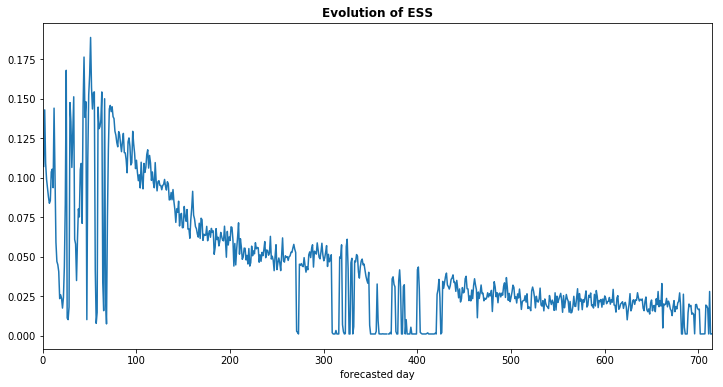

In [26]:
fig=plt.figure(figsize=(12,6))
plt.plot(range(1,n_pred),ESS_calc[0,1:n_pred]/M)
#plt.plot(range(1,n_pred),ESS_calc[1,1:n_pred]/M)
#plt.plot(range(1,n_pred),ESS_calc[2,1:n_pred]/M)

plt.title("Evolution of ESS",fontweight='bold')
plt.xlabel('forecasted day')
plt.xlim(0,n_pred)
plt.show()

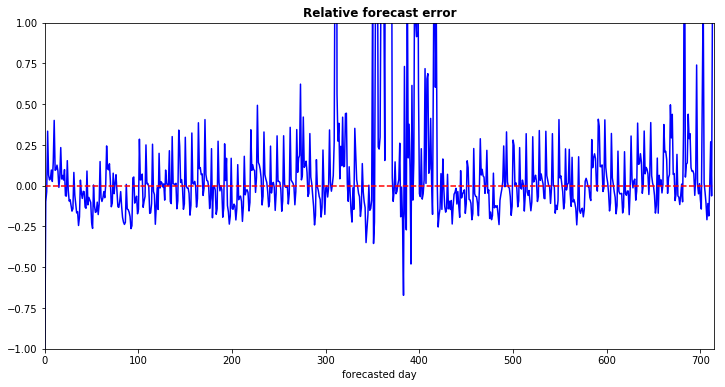

In [27]:
fig=plt.figure(figsize=(12,6))

plt.plot(range(n_pred),(x_predict[0,:]-consumption_day_ahead[:n_pred])/consumption_day_ahead[:n_pred],color='blue')
#plt.plot(range(n_pred),(x_predict[1,:]-consumption_day_ahead[1:n_pred+1])/consumption_day_ahead[1:n_pred+1],color='orange')
#plt.plot(range(n_pred),(x_predict[2,:]-consumption_day_ahead[2:n_pred+2])/consumption_day_ahead[2:n_pred+2],color='green')

plt.plot(range(n_pred-1),np.zeros(n_pred-1),color='red',linestyle='--')
plt.ylim(-1,1)
plt.xlim(0,n_pred)
plt.xlabel('forecasted day')
plt.title("Relative forecast error",fontweight='bold')
plt.show()

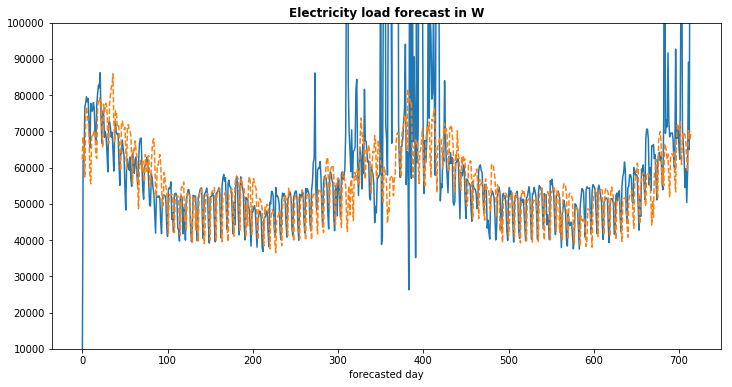

In [28]:
fig=plt.figure(figsize=(12,6))
plt.plot(range(n_pred),x_predict[0,:])
#plt.plot(range(n_pred),x_predict[1,:])
#plt.plot(range(n_pred),x_predict[2,:])
plt.plot(range(n_pred),consumption_day_ahead[:n_pred],linestyle='--')
plt.xlabel('forecasted day')
plt.ylim(10**4,10**5)
plt.title("Electricity load forecast in W",fontweight='bold')
plt.show()

Goal: re-estimate the one-dimensional parameters ($\sigma_g,\sigma_s,\mu_h,\kappa,\sigma$)<br>
Proposal distribution for these parameters: truncated gaussian random walk<br>
We set kappa constant at 1/8



## PMMH

#### Initialization of parameters

In [29]:
len_filter_pmmh=715
len_iter_mha=300

#### PMMH Algorithm

In [30]:
pf.pmmh(len_filter_pmmh, len_iter_mha, pred_forward, len_init)

log_prior_init= -56.3146626545
n= 1
mean s: 1.34e+04
x_pred_mean = 4.01e+04 real consumption= 6.86e+04
x_pred min= 7.70e+02 x_pred max 1.90e+05
ESS of normalized weights= 229.08158
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 2
mean s: 2.13e+04
x_pred_mean = 6.43e+04 real consumption= 6.41e+04
x_pred min= 6.68e+02 x_pred max 2.81e+05
ESS of normalized weights= 307.863136
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 3
mean s: 2.85e+04
x_pred_mean = 9.62e+04 real consumption= 5.74e+04
x_pred min= 1.80e+03 x_pred max 4.01e+05
ESS of normalized weights= 231.695128
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 4
mean s: 3.61e+04
x_pred_mean = 1.23e+05 real consumption= 7.31e+04
x_pred min= 8.21e+02 x_pred max 4.48e+05
ESS of normalized weights= 195.240327
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 5
mean s: 4.16e+04
x_pred_mean = 1.30e+05 real consumption= 7.68e+04
x_pred min= 1.

new ESS= 1000.0
------------------------
n= 41
mean s: 2.94e+05
No heating effect
x_pred_mean = 3.27e+04 real consumption= 7.16e+04
x_pred min= 4.64e+01 x_pred max 1.54e+05
ESS of normalized weights= 160.946399
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 42
mean s: 2.99e+05
x_pred_mean = 1.89e+05 real consumption= 7.21e+04
x_pred min= 1.23e+04 x_pred max 6.79e+05
ESS of normalized weights= 111.48447
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 43
mean s: 3.06e+05
No heating effect
x_pred_mean = 3.40e+04 real consumption= 7.10e+04
x_pred min= 2.45e+01 x_pred max 1.63e+05
ESS of normalized weights= 248.859086
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 44
mean s: 3.12e+05
No heating effect
x_pred_mean = 3.46e+04 real consumption= 6.39e+04
x_pred min= 8.40e+00 x_pred max 1.53e+05
ESS of normalized weights= 319.611515
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 45
mean s: 3.15

new ESS= 1000.0
------------------------
n= 77
mean s: 4.85e+05
No heating effect
x_pred_mean = 5.39e+04 real consumption= 6.31e+04
x_pred min= 2.75e+02 x_pred max 2.98e+05
ESS of normalized weights= 302.618653
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 78
mean s: 4.87e+05
No heating effect
x_pred_mean = 5.41e+04 real consumption= 6.33e+04
x_pred min= 9.39e+01 x_pred max 3.01e+05
ESS of normalized weights= 335.13331
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 79
mean s: 4.89e+05
No heating effect
x_pred_mean = 5.43e+04 real consumption= 5.73e+04
x_pred min= 3.91e+02 x_pred max 3.09e+05
ESS of normalized weights= 353.762119
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 80
mean s: 4.95e+05
No heating effect
x_pred_mean = 5.49e+04 real consumption= 5.46e+04
x_pred min= 4.26e+02 x_pred max 3.15e+05
ESS of normalized weights= 359.353177
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------


new ESS= 1000.0
------------------------
n= 113
mean s: 6.17e+05
No heating effect
x_pred_mean = 6.86e+04 real consumption= 5.14e+04
x_pred min= 3.37e+02 x_pred max 2.86e+05
ESS of normalized weights= 327.497394
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 114
mean s: 6.23e+05
No heating effect
x_pred_mean = 6.93e+04 real consumption= 4.47e+04
x_pred min= 1.63e+02 x_pred max 2.76e+05
ESS of normalized weights= 334.890957
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 115
mean s: 6.29e+05
No heating effect
x_pred_mean = 6.99e+04 real consumption= 4.14e+04
x_pred min= 1.75e+02 x_pred max 2.75e+05
ESS of normalized weights= 304.137169
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 116
mean s: 6.31e+05
No heating effect
x_pred_mean = 7.01e+04 real consumption= 5.42e+04
x_pred min= 3.06e+01 x_pred max 2.76e+05
ESS of normalized weights= 294.715597
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
--------------------

new ESS= 1000.0
------------------------
n= 148
mean s: 7.50e+05
No heating effect
x_pred_mean = 8.33e+04 real consumption= 5.18e+04
x_pred min= 1.28e+02 x_pred max 3.66e+05
ESS of normalized weights= 270.616413
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 149
mean s: 7.53e+05
No heating effect
x_pred_mean = 8.37e+04 real consumption= 4.41e+04
x_pred min= 7.18e+01 x_pred max 3.52e+05
ESS of normalized weights= 285.975171
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 150
mean s: 7.53e+05
No heating effect
x_pred_mean = 8.36e+04 real consumption= 4.00e+04
x_pred min= 6.76e+02 x_pred max 3.43e+05
ESS of normalized weights= 254.323466
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 151
mean s: 7.52e+05
No heating effect
x_pred_mean = 8.35e+04 real consumption= 5.20e+04
x_pred min= 4.97e+02 x_pred max 3.47e+05
ESS of normalized weights= 248.549337
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
--------------------

new ESS= 1000.0
------------------------
n= 184
mean s: 9.48e+05
No heating effect
x_pred_mean = 1.05e+05 real consumption= 4.83e+04
x_pred min= 1.12e+02 x_pred max 4.67e+05
ESS of normalized weights= 223.140444
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 185
mean s: 9.49e+05
No heating effect
x_pred_mean = 1.05e+05 real consumption= 4.27e+04
x_pred min= 3.55e+02 x_pred max 4.81e+05
ESS of normalized weights= 221.20091
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 186
mean s: 9.52e+05
No heating effect
x_pred_mean = 1.06e+05 real consumption= 5.63e+04
x_pred min= 2.43e+01 x_pred max 4.98e+05
ESS of normalized weights= 206.761948
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 187
mean s: 9.52e+05
No heating effect
x_pred_mean = 1.06e+05 real consumption= 5.71e+04
x_pred min= 1.46e+02 x_pred max 5.13e+05
ESS of normalized weights= 207.856443
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
---------------------

x_pred min= 8.23e+01 x_pred max 5.04e+05
ESS of normalized weights= 184.093868
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 220
mean s: 1.10e+06
No heating effect
x_pred_mean = 1.22e+05 real consumption= 3.76e+04
x_pred min= 3.14e+02 x_pred max 5.12e+05
ESS of normalized weights= 181.045462
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 221
mean s: 1.10e+06
No heating effect
x_pred_mean = 1.22e+05 real consumption= 4.57e+04
x_pred min= 1.01e+02 x_pred max 5.08e+05
ESS of normalized weights= 189.494876
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 222
mean s: 1.10e+06
No heating effect
x_pred_mean = 1.23e+05 real consumption= 4.74e+04
x_pred min= 2.39e+02 x_pred max 4.96e+05
ESS of normalized weights= 176.793817
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 223
mean s: 1.11e+06
No heating effect
x_pred_mean = 1.23e+05 real consumption= 4.85e+04
x_pred min= 1.64e+02 x_pred max 4.96

new ESS= 1000.0
------------------------
n= 255
mean s: 1.21e+06
No heating effect
x_pred_mean = 1.34e+05 real consumption= 4.03e+04
x_pred min= 2.82e+02 x_pred max 5.45e+05
ESS of normalized weights= 188.512989
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 256
mean s: 1.21e+06
No heating effect
x_pred_mean = 1.35e+05 real consumption= 5.15e+04
x_pred min= 1.04e+02 x_pred max 5.43e+05
ESS of normalized weights= 177.394155
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 257
mean s: 1.21e+06
No heating effect
x_pred_mean = 1.35e+05 real consumption= 5.22e+04
x_pred min= 3.73e+02 x_pred max 5.45e+05
ESS of normalized weights= 173.181645
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 258
mean s: 1.22e+06
No heating effect
x_pred_mean = 1.36e+05 real consumption= 5.38e+04
x_pred min= 4.43e+02 x_pred max 5.63e+05
ESS of normalized weights= 172.878699
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
--------------------

new ESS= 1000.0
------------------------
n= 290
mean s: 1.30e+06
No heating effect
x_pred_mean = 1.45e+05 real consumption= 4.87e+04
x_pred min= 1.99e+03 x_pred max 6.38e+05
ESS of normalized weights= 137.66524
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 291
mean s: 1.30e+06
No heating effect
x_pred_mean = 1.45e+05 real consumption= 5.92e+04
x_pred min= 4.86e+02 x_pred max 6.36e+05
ESS of normalized weights= 137.010253
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 292
mean s: 1.30e+06
No heating effect
x_pred_mean = 1.44e+05 real consumption= 5.99e+04
x_pred min= 6.93e+01 x_pred max 6.57e+05
ESS of normalized weights= 135.287034
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 293
mean s: 1.30e+06
No heating effect
x_pred_mean = 1.44e+05 real consumption= 6.04e+04
x_pred min= 9.14e+01 x_pred max 6.65e+05
ESS of normalized weights= 140.435603
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
---------------------

new ESS= 1000.0
------------------------
n= 327
mean s: 1.32e+06
x_pred_mean = 3.77e+06 real consumption= 7.37e+04
x_pred min= 3.01e+04 x_pred max 1.48e+07
ESS of normalized weights= 2.473629
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 328
mean s: 1.32e+06
x_pred_mean = 1.04e+07 real consumption= 6.96e+04
x_pred min= 1.27e+05 x_pred max 4.20e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 329
mean s: 1.32e+06
No heating effect
x_pred_mean = 1.46e+05 real consumption= 6.73e+04
x_pred min= 6.44e+02 x_pred max 6.85e+05
ESS of normalized weights= 156.781735
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 330
mean s: 1.32e+06
No heating effect
x_pred_mean = 1.46e+05 real consumption= 6.82e+04
x_pred min= 2.03e+02 x_pred max 6.81e+05
ESS of normalized weights= 155.5507
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 331
mean s: 1.32e+06
x_pred_mean = 3.38

------------------------
n= 366
mean s: 1.32e+06
x_pred_mean = 2.20e+07 real consumption= 5.66e+04
x_pred min= 2.34e+05 x_pred max 9.48e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 367
mean s: 1.32e+06
x_pred_mean = 2.92e+07 real consumption= 5.75e+04
x_pred min= 4.34e+05 x_pred max 1.28e+08
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 368
mean s: 1.32e+06
x_pred_mean = 2.39e+07 real consumption= 6.65e+04
x_pred min= 1.13e+05 x_pred max 1.06e+08
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 369
mean s: 1.32e+06
x_pred_mean = 2.23e+07 real consumption= 6.92e+04
x_pred min= 1.35e+05 x_pred max 1.03e+08
ESS of normalized weights= 1.00454
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 370
mean s: 1.32e+06
x_pred_mean = 1.83e+07 real consumption= 6.97e+04
x_pred min= 1.63e+05 x_pred max 8

new ESS= 1000.0
------------------------
n= 404
mean s: 1.35e+06
x_pred_mean = 2.29e+06 real consumption= 7.02e+04
x_pred min= 5.60e+04 x_pred max 9.92e+06
ESS of normalized weights= 1.820858
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 405
mean s: 1.35e+06
x_pred_mean = 1.11e+07 real consumption= 7.12e+04
x_pred min= 7.88e+04 x_pred max 4.92e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 406
mean s: 1.35e+06
x_pred_mean = 1.05e+07 real consumption= 7.03e+04
x_pred min= 6.12e+04 x_pred max 4.53e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 407
mean s: 1.35e+06
x_pred_mean = 1.24e+07 real consumption= 7.26e+04
x_pred min= 3.88e+04 x_pred max 5.55e+07
ESS of normalized weights= 1.000005
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 408
mean s: 1.36e+06
x_pred_mean = 1.13e+07 real consumption= 6.22e+04
x_pred min=

new ESS= 1000.0
------------------------
n= 441
mean s: 1.42e+06
No heating effect
x_pred_mean = 1.58e+05 real consumption= 6.47e+04
x_pred min= 2.03e+03 x_pred max 7.99e+05
ESS of normalized weights= 147.461959
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 442
mean s: 1.42e+06
No heating effect
x_pred_mean = 1.58e+05 real consumption= 6.19e+04
x_pred min= 3.59e+02 x_pred max 8.01e+05
ESS of normalized weights= 150.975851
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 443
mean s: 1.42e+06
No heating effect
x_pred_mean = 1.58e+05 real consumption= 5.69e+04
x_pred min= 6.15e+02 x_pred max 7.96e+05
ESS of normalized weights= 144.361224
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 444
mean s: 1.42e+06
No heating effect
x_pred_mean = 1.58e+05 real consumption= 5.38e+04
x_pred min= 3.88e+02 x_pred max 7.87e+05
ESS of normalized weights= 139.909106
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
--------------------

new ESS= 1000.0
------------------------
n= 479
mean s: 1.50e+06
No heating effect
x_pred_mean = 1.67e+05 real consumption= 4.79e+04
x_pred min= 7.91e+02 x_pred max 7.81e+05
ESS of normalized weights= 137.145057
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 480
mean s: 1.50e+06
No heating effect
x_pred_mean = 1.67e+05 real consumption= 6.07e+04
x_pred min= 1.35e+03 x_pred max 7.56e+05
ESS of normalized weights= 137.189707
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 481
mean s: 1.50e+06
No heating effect
x_pred_mean = 1.67e+05 real consumption= 6.10e+04
x_pred min= 8.93e+02 x_pred max 7.72e+05
ESS of normalized weights= 139.800526
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 482
mean s: 1.51e+06
No heating effect
x_pred_mean = 1.67e+05 real consumption= 6.08e+04
x_pred min= 9.21e+02 x_pred max 7.84e+05
ESS of normalized weights= 146.247901
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
--------------------

new ESS= 1000.0
------------------------
n= 515
mean s: 1.61e+06
No heating effect
x_pred_mean = 1.79e+05 real consumption= 5.22e+04
x_pred min= 2.42e+02 x_pred max 8.01e+05
ESS of normalized weights= 128.703024
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 516
mean s: 1.61e+06
No heating effect
x_pred_mean = 1.79e+05 real consumption= 5.37e+04
x_pred min= 2.18e+01 x_pred max 8.11e+05
ESS of normalized weights= 128.825661
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 517
mean s: 1.62e+06
No heating effect
x_pred_mean = 1.80e+05 real consumption= 5.29e+04
x_pred min= 3.77e+02 x_pred max 8.11e+05
ESS of normalized weights= 129.29057
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 518
mean s: 1.62e+06
No heating effect
x_pred_mean = 1.81e+05 real consumption= 5.38e+04
x_pred min= 2.94e+02 x_pred max 7.97e+05
ESS of normalized weights= 127.633159
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
---------------------

new ESS= 1000.0
------------------------
n= 551
mean s: 1.83e+06
No heating effect
x_pred_mean = 2.03e+05 real consumption= 5.35e+04
x_pred min= 2.25e+02 x_pred max 1.03e+06
ESS of normalized weights= 116.186199
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 552
mean s: 1.83e+06
No heating effect
x_pred_mean = 2.04e+05 real consumption= 5.36e+04
x_pred min= 1.41e+03 x_pred max 1.03e+06
ESS of normalized weights= 114.953676
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 553
mean s: 1.84e+06
No heating effect
x_pred_mean = 2.04e+05 real consumption= 5.47e+04
x_pred min= 1.56e+03 x_pred max 1.04e+06
ESS of normalized weights= 109.901707
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 554
mean s: 1.84e+06
No heating effect
x_pred_mean = 2.04e+05 real consumption= 5.40e+04
x_pred min= 3.48e+02 x_pred max 1.06e+06
ESS of normalized weights= 103.94085
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
---------------------

new ESS= 1000.0
------------------------
n= 587
mean s: 1.98e+06
No heating effect
x_pred_mean = 2.20e+05 real consumption= 4.52e+04
x_pred min= 5.31e+00 x_pred max 1.21e+06
ESS of normalized weights= 92.581408
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 588
mean s: 1.98e+06
No heating effect
x_pred_mean = 2.20e+05 real consumption= 4.56e+04
x_pred min= 2.94e+01 x_pred max 1.22e+06
ESS of normalized weights= 100.575112
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 589
mean s: 1.99e+06
No heating effect
x_pred_mean = 2.21e+05 real consumption= 4.62e+04
x_pred min= 4.05e+02 x_pred max 1.22e+06
ESS of normalized weights= 94.146427
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 590
mean s: 1.99e+06
No heating effect
x_pred_mean = 2.21e+05 real consumption= 4.22e+04
x_pred min= 1.93e+02 x_pred max 1.21e+06
ESS of normalized weights= 92.946177
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
-----------------------

new ESS= 1000.0
------------------------
n= 623
mean s: 2.14e+06
No heating effect
x_pred_mean = 2.38e+05 real consumption= 5.17e+04
x_pred min= 2.97e+02 x_pred max 1.31e+06
ESS of normalized weights= 82.807781
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 624
mean s: 2.14e+06
No heating effect
x_pred_mean = 2.38e+05 real consumption= 5.06e+04
x_pred min= 2.87e+02 x_pred max 1.33e+06
ESS of normalized weights= 77.771466
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 625
mean s: 2.14e+06
No heating effect
x_pred_mean = 2.38e+05 real consumption= 4.32e+04
x_pred min= 4.62e+01 x_pred max 1.36e+06
ESS of normalized weights= 77.229807
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 626
mean s: 2.14e+06
No heating effect
x_pred_mean = 2.38e+05 real consumption= 4.01e+04
x_pred min= 2.96e+01 x_pred max 1.36e+06
ESS of normalized weights= 75.628557
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------

new ESS= 1000.0
------------------------
n= 659
mean s: 2.29e+06
No heating effect
x_pred_mean = 2.54e+05 real consumption= 5.78e+04
x_pred min= 2.14e+03 x_pred max 1.18e+06
ESS of normalized weights= 79.042218
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 660
mean s: 2.29e+06
No heating effect
x_pred_mean = 2.55e+05 real consumption= 5.08e+04
x_pred min= 1.17e+03 x_pred max 1.19e+06
ESS of normalized weights= 82.023135
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 661
mean s: 2.29e+06
No heating effect
x_pred_mean = 2.54e+05 real consumption= 4.94e+04
x_pred min= 4.46e+02 x_pred max 1.19e+06
ESS of normalized weights= 81.099163
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 662
mean s: 2.29e+06
x_pred_mean = 1.11e+06 real consumption= 5.85e+04
x_pred min= 4.67e+04 x_pred max 4.46e+06
ESS of normalized weights= 4.652806
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 663
mean s: 2.2

new ESS= 1000.0
------------------------
n= 698
mean s: 2.48e+06
No heating effect
x_pred_mean = 2.75e+05 real consumption= 7.18e+04
x_pred min= 5.56e+02 x_pred max 1.58e+06
ESS of normalized weights= 91.090274
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 699
mean s: 2.47e+06
No heating effect
x_pred_mean = 2.75e+05 real consumption= 7.05e+04
x_pred min= 2.89e+03 x_pred max 1.58e+06
ESS of normalized weights= 87.697335
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 700
mean s: 2.48e+06
No heating effect
x_pred_mean = 2.75e+05 real consumption= 7.11e+04
x_pred min= 4.26e+02 x_pred max 1.58e+06
ESS of normalized weights= 84.056439
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 701
mean s: 2.48e+06
No heating effect
x_pred_mean = 2.76e+05 real consumption= 7.27e+04
x_pred min= 5.80e+01 x_pred max 1.59e+06
ESS of normalized weights= 83.312234
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------

n= 22
mean s: 1.54e+05
x_pred_mean = 3.68e+05 real consumption= 7.89e+04
x_pred min= 1.45e+03 x_pred max 1.52e+06
ESS of normalized weights= 32.550125
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 23
mean s: 1.58e+05
x_pred_mean = 3.01e+05 real consumption= 7.12e+04
x_pred min= 1.02e+04 x_pred max 1.17e+06
ESS of normalized weights= 37.015661
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 24
mean s: 1.61e+05
x_pred_mean = 1.67e+05 real consumption= 6.55e+04
x_pred min= 2.37e+03 x_pred max 5.88e+05
ESS of normalized weights= 93.577473
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 25
mean s: 1.65e+05
x_pred_mean = 1.01e+05 real consumption= 7.75e+04
x_pred min= 4.75e+03 x_pred max 3.40e+05
ESS of normalized weights= 157.138689
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 26
mean s: 1.69e+05
No heating effect
x_pred_mean = 1.88e+04 real consumption= 7.54e+04
x_pred min= 3.69e+01 x_p

x_pred_mean = 3.38e+04 real consumption= 6.47e+04
x_pred min= 1.13e+01 x_pred max 1.20e+05
ESS of normalized weights= 154.75973
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 62
mean s: 3.09e+05
No heating effect
x_pred_mean = 3.44e+04 real consumption= 6.74e+04
x_pred min= 5.22e+01 x_pred max 1.16e+05
ESS of normalized weights= 142.829628
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 63
mean s: 3.14e+05
No heating effect
x_pred_mean = 3.48e+04 real consumption= 6.53e+04
x_pred min= 1.27e+02 x_pred max 1.22e+05
ESS of normalized weights= 140.812405
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 64
mean s: 3.20e+05
x_pred_mean = 1.99e+05 real consumption= 6.30e+04
x_pred min= 1.07e+04 x_pred max 6.45e+05
ESS of normalized weights= 60.291539
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 65
mean s: 3.27e+05
x_pred_mean = 3.32e+05 real consumption= 5.49e+04
x_pred min= 1.47e+04 x_pred 

new ESS= 1000.0
------------------------
n= 98
mean s: 5.72e+05
No heating effect
x_pred_mean = 6.35e+04 real consumption= 5.49e+04
x_pred min= 2.56e+02 x_pred max 2.34e+05
ESS of normalized weights= 218.928026
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 99
mean s: 5.77e+05
No heating effect
x_pred_mean = 6.42e+04 real consumption= 5.35e+04
x_pred min= 8.85e+01 x_pred max 2.43e+05
ESS of normalized weights= 214.360974
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 100
mean s: 5.86e+05
No heating effect
x_pred_mean = 6.52e+04 real consumption= 4.79e+04
x_pred min= 1.36e+02 x_pred max 2.47e+05
ESS of normalized weights= 201.264822
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 101
mean s: 5.96e+05
No heating effect
x_pred_mean = 6.62e+04 real consumption= 4.19e+04
x_pred min= 1.92e+01 x_pred max 2.68e+05
ESS of normalized weights= 199.327545
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
----------------------

new ESS= 1000.0
------------------------
n= 134
mean s: 9.22e+05
No heating effect
x_pred_mean = 1.02e+05 real consumption= 4.84e+04
x_pred min= 2.74e+02 x_pred max 4.02e+05
ESS of normalized weights= 149.24523
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 135
mean s: 9.28e+05
No heating effect
x_pred_mean = 1.03e+05 real consumption= 4.47e+04
x_pred min= 1.80e+02 x_pred max 4.23e+05
ESS of normalized weights= 156.461271
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 136
mean s: 9.45e+05
No heating effect
x_pred_mean = 1.05e+05 real consumption= 3.98e+04
x_pred min= 5.52e+02 x_pred max 4.37e+05
ESS of normalized weights= 145.684783
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 137
mean s: 9.56e+05
No heating effect
x_pred_mean = 1.06e+05 real consumption= 5.18e+04
x_pred min= 1.70e+02 x_pred max 4.44e+05
ESS of normalized weights= 148.913253
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
---------------------

new ESS= 1000.0
------------------------
n= 169
mean s: 1.27e+06
No heating effect
x_pred_mean = 1.41e+05 real consumption= 5.13e+04
x_pred min= 2.51e+03 x_pred max 6.45e+05
ESS of normalized weights= 104.537921
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 170
mean s: 1.28e+06
No heating effect
x_pred_mean = 1.42e+05 real consumption= 4.36e+04
x_pred min= 9.57e+01 x_pred max 6.36e+05
ESS of normalized weights= 94.749659
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 171
mean s: 1.30e+06
No heating effect
x_pred_mean = 1.44e+05 real consumption= 3.96e+04
x_pred min= 4.99e+02 x_pred max 6.19e+05
ESS of normalized weights= 99.140077
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 172
mean s: 1.31e+06
No heating effect
x_pred_mean = 1.45e+05 real consumption= 5.29e+04
x_pred min= 4.95e+02 x_pred max 5.77e+05
ESS of normalized weights= 85.928192
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
-----------------------

new ESS= 1000.0
------------------------
n= 206
mean s: 1.57e+06
No heating effect
x_pred_mean = 1.75e+05 real consumption= 4.01e+04
x_pred min= 7.36e+02 x_pred max 7.22e+05
ESS of normalized weights= 80.998864
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 207
mean s: 1.58e+06
No heating effect
x_pred_mean = 1.75e+05 real consumption= 5.12e+04
x_pred min= 7.31e+02 x_pred max 7.10e+05
ESS of normalized weights= 89.583124
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 208
mean s: 1.58e+06
No heating effect
x_pred_mean = 1.75e+05 real consumption= 5.15e+04
x_pred min= 1.46e+02 x_pred max 7.11e+05
ESS of normalized weights= 84.763305
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 209
mean s: 1.59e+06
No heating effect
x_pred_mean = 1.76e+05 real consumption= 5.11e+04
x_pred min= 1.00e+02 x_pred max 7.17e+05
ESS of normalized weights= 86.075697
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------

new ESS= 1000.0
------------------------
n= 242
mean s: 1.73e+06
No heating effect
x_pred_mean = 1.92e+05 real consumption= 5.43e+04
x_pred min= 3.16e+02 x_pred max 7.60e+05
ESS of normalized weights= 68.515407
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 243
mean s: 1.73e+06
No heating effect
x_pred_mean = 1.92e+05 real consumption= 5.28e+04
x_pred min= 6.50e+02 x_pred max 7.58e+05
ESS of normalized weights= 73.369477
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 244
mean s: 1.74e+06
No heating effect
x_pred_mean = 1.93e+05 real consumption= 5.20e+04
x_pred min= 1.20e+02 x_pred max 7.73e+05
ESS of normalized weights= 79.329462
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 245
mean s: 1.74e+06
No heating effect
x_pred_mean = 1.93e+05 real consumption= 5.17e+04
x_pred min= 1.26e+03 x_pred max 8.11e+05
ESS of normalized weights= 90.618997
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------

new ESS= 1000.0
------------------------
n= 278
mean s: 1.89e+06
No heating effect
x_pred_mean = 2.10e+05 real consumption= 5.32e+04
x_pred min= 4.60e+02 x_pred max 8.08e+05
ESS of normalized weights= 64.574571
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 279
mean s: 1.90e+06
No heating effect
x_pred_mean = 2.11e+05 real consumption= 5.36e+04
x_pred min= 1.24e+03 x_pred max 8.05e+05
ESS of normalized weights= 71.78151
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 280
mean s: 1.92e+06
No heating effect
x_pred_mean = 2.13e+05 real consumption= 5.32e+04
x_pred min= 5.04e+01 x_pred max 8.00e+05
ESS of normalized weights= 73.535826
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 281
mean s: 1.91e+06
No heating effect
x_pred_mean = 2.12e+05 real consumption= 5.22e+04
x_pred min= 5.15e+01 x_pred max 7.99e+05
ESS of normalized weights= 76.07368
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n

new ESS= 1000.0
------------------------
n= 313
mean s: 2.20e+06
x_pred_mean = 1.76e+06 real consumption= 5.49e+04
x_pred min= 4.17e+04 x_pred max 6.79e+06
ESS of normalized weights= 1.066398
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 314
mean s: 2.22e+06
x_pred_mean = 3.21e+06 real consumption= 4.69e+04
x_pred min= 7.70e+04 x_pred max 1.30e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 315
mean s: 2.24e+06
x_pred_mean = 3.87e+06 real consumption= 5.65e+04
x_pred min= 9.08e+04 x_pred max 1.59e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 316
mean s: 2.25e+06
x_pred_mean = 2.52e+06 real consumption= 5.67e+04
x_pred min= 8.51e+04 x_pred max 1.01e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 317
mean s: 2.25e+06
No heating effect
x_pred_mean = 2.49e+05 real consumption= 5.10e+0

new ESS= 1000.0
------------------------
n= 350
mean s: 2.52e+06
x_pred_mean = 2.76e+06 real consumption= 6.13e+04
x_pred min= 4.04e+04 x_pred max 1.09e+07
ESS of normalized weights= 1.00056
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 351
mean s: 2.52e+06
x_pred_mean = 2.42e+06 real consumption= 6.01e+04
x_pred min= 2.52e+04 x_pred max 9.36e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 352
mean s: 2.53e+06
x_pred_mean = 3.56e+06 real consumption= 5.26e+04
x_pred min= 1.16e+05 x_pred max 1.41e+07
ESS of normalized weights= 1.536685
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 353
mean s: 2.54e+06
x_pred_mean = 2.21e+06 real consumption= 5.06e+04
x_pred min= 6.08e+04 x_pred max 8.46e+06
ESS of normalized weights= 1.94488
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 354
mean s: 2.54e+06
x_pred_mean = 4.44e+06 real consumption= 6.01e+04
x_pred m

x_pred min= 1.41e+05 x_pred max 1.72e+07
ESS of normalized weights= 1.860929
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 391
mean s: 2.89e+06
x_pred_mean = 4.89e+06 real consumption= 6.76e+04
x_pred min= 8.70e+04 x_pred max 1.89e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 392
mean s: 2.90e+06
x_pred_mean = 4.09e+06 real consumption= 6.68e+04
x_pred min= 9.41e+04 x_pred max 1.56e+07
ESS of normalized weights= 1.010256
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 393
mean s: 2.91e+06
x_pred_mean = 4.94e+05 real consumption= 6.73e+04
x_pred min= 2.06e+04 x_pred max 1.46e+06
ESS of normalized weights= 6.466453
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 394
mean s: 2.93e+06
x_pred_mean = 3.45e+06 real consumption= 6.15e+04
x_pred min= 1.01e+05 x_pred max 1.29e+07
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
----

x_pred_mean = 3.58e+05 real consumption= 6.19e+04
x_pred min= 3.34e+02 x_pred max 1.70e+06
ESS of normalized weights= 44.913825
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 430
mean s: 3.23e+06
No heating effect
x_pred_mean = 3.58e+05 real consumption= 5.89e+04
x_pred min= 1.03e+03 x_pred max 1.77e+06
ESS of normalized weights= 39.084173
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 431
mean s: 3.24e+06
No heating effect
x_pred_mean = 3.60e+05 real consumption= 7.10e+04
x_pred min= 2.59e+03 x_pred max 1.75e+06
ESS of normalized weights= 35.144484
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 432
mean s: 3.25e+06
No heating effect
x_pred_mean = 3.61e+05 real consumption= 7.09e+04
x_pred min= 3.04e+02 x_pred max 1.81e+06
ESS of normalized weights= 39.469097
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 433
mean s: 3.27e+06
No heating effect
x_pred_mean = 3.63e+05 real consumption=

new ESS= 1000.0
------------------------
n= 466
mean s: 3.55e+06
No heating effect
x_pred_mean = 3.95e+05 real consumption= 5.68e+04
x_pred min= 5.92e+02 x_pred max 1.74e+06
ESS of normalized weights= 29.028674
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 467
mean s: 3.58e+06
No heating effect
x_pred_mean = 3.98e+05 real consumption= 5.52e+04
x_pred min= 1.83e+03 x_pred max 1.78e+06
ESS of normalized weights= 35.660647
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 468
mean s: 3.59e+06
No heating effect
x_pred_mean = 3.99e+05 real consumption= 5.58e+04
x_pred min= 1.74e+02 x_pred max 1.71e+06
ESS of normalized weights= 37.339462
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 469
mean s: 3.60e+06
No heating effect
x_pred_mean = 4.00e+05 real consumption= 5.57e+04
x_pred min= 1.60e+03 x_pred max 1.73e+06
ESS of normalized weights= 37.547729
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------

new ESS= 1000.0
------------------------
n= 502
mean s: 3.88e+06
No heating effect
x_pred_mean = 4.31e+05 real consumption= 5.19e+04
x_pred min= 2.73e+02 x_pred max 1.64e+06
ESS of normalized weights= 32.563572
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 503
mean s: 3.89e+06
No heating effect
x_pred_mean = 4.33e+05 real consumption= 5.26e+04
x_pred min= 7.51e+02 x_pred max 1.64e+06
ESS of normalized weights= 36.651093
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 504
mean s: 3.91e+06
No heating effect
x_pred_mean = 4.34e+05 real consumption= 5.31e+04
x_pred min= 1.40e+03 x_pred max 1.71e+06
ESS of normalized weights= 35.942488
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 505
mean s: 3.90e+06
No heating effect
x_pred_mean = 4.33e+05 real consumption= 5.16e+04
x_pred min= 2.09e+02 x_pred max 1.68e+06
ESS of normalized weights= 33.503219
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------

new ESS= 1000.0
------------------------
n= 539
mean s: 4.13e+06
No heating effect
x_pred_mean = 4.59e+05 real consumption= 5.44e+04
x_pred min= 8.61e+02 x_pred max 1.94e+06
ESS of normalized weights= 28.375436
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 540
mean s: 4.17e+06
No heating effect
x_pred_mean = 4.63e+05 real consumption= 5.25e+04
x_pred min= 3.84e+02 x_pred max 2.02e+06
ESS of normalized weights= 25.46929
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 541
mean s: 4.18e+06
No heating effect
x_pred_mean = 4.64e+05 real consumption= 4.39e+04
x_pred min= 3.28e+03 x_pred max 2.01e+06
ESS of normalized weights= 23.642482
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 542
mean s: 4.17e+06
No heating effect
x_pred_mean = 4.63e+05 real consumption= 4.00e+04
x_pred min= 1.82e+03 x_pred max 1.98e+06
ESS of normalized weights= 32.105422
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------


new ESS= 1000.0
------------------------
n= 574
mean s: 4.53e+06
No heating effect
x_pred_mean = 5.03e+05 real consumption= 5.21e+04
x_pred min= 3.87e+03 x_pred max 2.08e+06
ESS of normalized weights= 24.422913
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 575
mean s: 4.54e+06
No heating effect
x_pred_mean = 5.05e+05 real consumption= 5.10e+04
x_pred min= 3.27e+03 x_pred max 2.11e+06
ESS of normalized weights= 23.321289
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 576
mean s: 4.54e+06
No heating effect
x_pred_mean = 5.04e+05 real consumption= 4.41e+04
x_pred min= 9.77e+02 x_pred max 2.13e+06
ESS of normalized weights= 19.114009
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 577
mean s: 4.54e+06
No heating effect
x_pred_mean = 5.05e+05 real consumption= 3.90e+04
x_pred min= 4.21e+02 x_pred max 2.15e+06
ESS of normalized weights= 19.760145
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------

new ESS= 1000.0
------------------------
n= 612
mean s: 4.86e+06
No heating effect
x_pred_mean = 5.40e+05 real consumption= 4.14e+04
x_pred min= 3.43e+03 x_pred max 2.13e+06
ESS of normalized weights= 26.45469
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 613
mean s: 4.85e+06
No heating effect
x_pred_mean = 5.39e+05 real consumption= 5.29e+04
x_pred min= 1.08e+03 x_pred max 2.16e+06
ESS of normalized weights= 13.757141
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 614
mean s: 4.86e+06
No heating effect
x_pred_mean = 5.40e+05 real consumption= 5.43e+04
x_pred min= 1.12e+03 x_pred max 2.22e+06
ESS of normalized weights= 23.4097
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 615
mean s: 4.86e+06
No heating effect
x_pred_mean = 5.40e+05 real consumption= 5.43e+04
x_pred min= 6.07e+02 x_pred max 2.19e+06
ESS of normalized weights= 19.846432
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n=

new ESS= 1000.0
------------------------
n= 650
mean s: 5.11e+06
No heating effect
x_pred_mean = 5.68e+05 real consumption= 5.83e+04
x_pred min= 2.33e+02 x_pred max 2.29e+06
ESS of normalized weights= 18.607952
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 651
mean s: 5.12e+06
No heating effect
x_pred_mean = 5.69e+05 real consumption= 6.12e+04
x_pred min= 2.27e+03 x_pred max 2.28e+06
ESS of normalized weights= 25.244784
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 652
mean s: 5.12e+06
No heating effect
x_pred_mean = 5.69e+05 real consumption= 5.96e+04
x_pred min= 4.57e+03 x_pred max 2.27e+06
ESS of normalized weights= 28.75423
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 653
mean s: 5.12e+06
No heating effect
x_pred_mean = 5.69e+05 real consumption= 4.86e+04
x_pred min= 1.69e+03 x_pred max 2.27e+06
ESS of normalized weights= 25.63426
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n

new ESS= 1000.0
------------------------
n= 685
mean s: 5.17e+06
x_pred_mean = 8.36e+05 real consumption= 6.47e+04
x_pred min= 2.74e+04 x_pred max 2.67e+06
ESS of normalized weights= 1.573388
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 686
mean s: 5.17e+06
x_pred_mean = 1.44e+06 real consumption= 6.25e+04
x_pred min= 9.44e+04 x_pred max 3.91e+06
ESS of normalized weights= 1.003457
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 687
mean s: 5.18e+06
x_pred_mean = 2.01e+06 real consumption= 6.37e+04
x_pred min= 8.02e+04 x_pred max 5.72e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 688
mean s: 5.18e+06
x_pred_mean = 1.83e+06 real consumption= 5.66e+04
x_pred min= 3.60e+04 x_pred max 5.20e+06
ESS of normalized weights= 1.000838
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 689
mean s: 5.18e+06
No heating effect
x_pred_mean = 5.76e+05 real consumptio

new ESS= 1000.0
------------------------
n= 5
mean s: 4.48e+04
x_pred_mean = 1.34e+05 real consumption= 7.68e+04
x_pred min= 1.26e+03 x_pred max 7.01e+05
ESS of normalized weights= 52.231646
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 6
mean s: 5.60e+04
x_pred_mean = 1.47e+05 real consumption= 7.49e+04
x_pred min= 1.63e+03 x_pred max 7.06e+05
ESS of normalized weights= 41.020172
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 7
mean s: 6.17e+04
x_pred_mean = 1.69e+05 real consumption= 7.21e+04
x_pred min= 1.97e+03 x_pred max 8.40e+05
ESS of normalized weights= 45.67653
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 8
mean s: 6.65e+04
x_pred_mean = 1.46e+05 real consumption= 6.90e+04
x_pred min= 1.25e+03 x_pred max 6.58e+05
ESS of normalized weights= 49.649893
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 9
mean s: 7.05e+04
x_pred_mean = 1.25e+05 real consumption= 5.72e+04
x_pred m

new ESS= 1000.0
------------------------
n= 42
mean s: 1.63e+05
x_pred_mean = 1.64e+05 real consumption= 7.21e+04
x_pred min= 5.53e+03 x_pred max 6.06e+05
ESS of normalized weights= 41.838876
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 43
mean s: 1.65e+05
No heating effect
x_pred_mean = 1.84e+04 real consumption= 7.10e+04
x_pred min= 4.22e+00 x_pred max 8.38e+04
ESS of normalized weights= 8.528361
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 44
mean s: 1.68e+05
No heating effect
x_pred_mean = 1.87e+04 real consumption= 6.39e+04
x_pred min= 6.46e+01 x_pred max 8.39e+04
ESS of normalized weights= 17.139268
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 45
mean s: 1.71e+05
No heating effect
x_pred_mean = 1.90e+04 real consumption= 5.91e+04
x_pred min= 1.32e+01 x_pred max 8.26e+04
ESS of normalized weights= 8.32502
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 46
mean s: 1.75e+05
N

new ESS= 1000.0
------------------------
n= 81
mean s: 3.12e+05
No heating effect
x_pred_mean = 3.47e+04 real consumption= 6.05e+04
x_pred min= 1.55e+02 x_pred max 1.36e+05
ESS of normalized weights= 69.744993
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 82
mean s: 3.20e+05
No heating effect
x_pred_mean = 3.55e+04 real consumption= 6.54e+04
x_pred min= 4.32e+02 x_pred max 1.41e+05
ESS of normalized weights= 87.852664
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 83
mean s: 3.23e+05
No heating effect
x_pred_mean = 3.59e+04 real consumption= 6.75e+04
x_pred min= 6.94e+01 x_pred max 1.51e+05
ESS of normalized weights= 95.672847
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 84
mean s: 3.28e+05
No heating effect
x_pred_mean = 3.65e+04 real consumption= 6.80e+04
x_pred min= 2.23e+02 x_pred max 1.54e+05
ESS of normalized weights= 99.537433
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 

new ESS= 1000.0
------------------------
n= 119
mean s: 5.61e+05
No heating effect
x_pred_mean = 6.24e+04 real consumption= 5.60e+04
x_pred min= 1.09e+02 x_pred max 2.57e+05
ESS of normalized weights= 86.262642
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 120
mean s: 5.69e+05
No heating effect
x_pred_mean = 6.32e+04 real consumption= 4.54e+04
x_pred min= 2.05e+02 x_pred max 2.73e+05
ESS of normalized weights= 88.554915
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 121
mean s: 5.75e+05
No heating effect
x_pred_mean = 6.39e+04 real consumption= 4.68e+04
x_pred min= 2.90e+02 x_pred max 2.63e+05
ESS of normalized weights= 95.471186
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 122
mean s: 5.79e+05
No heating effect
x_pred_mean = 6.43e+04 real consumption= 4.28e+04
x_pred min= 3.36e+02 x_pred max 2.71e+05
ESS of normalized weights= 84.009085
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------

new ESS= 1000.0
------------------------
n= 154
mean s: 6.49e+05
No heating effect
x_pred_mean = 7.21e+04 real consumption= 5.43e+04
x_pred min= 3.33e+01 x_pred max 3.21e+05
ESS of normalized weights= 72.088752
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 155
mean s: 6.48e+05
No heating effect
x_pred_mean = 7.21e+04 real consumption= 5.44e+04
x_pred min= 1.05e+02 x_pred max 3.25e+05
ESS of normalized weights= 67.618409
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 156
mean s: 6.52e+05
No heating effect
x_pred_mean = 7.24e+04 real consumption= 4.49e+04
x_pred min= 2.88e+02 x_pred max 3.28e+05
ESS of normalized weights= 78.343
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 157
mean s: 6.58e+05
No heating effect
x_pred_mean = 7.31e+04 real consumption= 3.99e+04
x_pred min= 3.39e+02 x_pred max 3.26e+05
ESS of normalized weights= 70.160262
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n=

new ESS= 1000.0
------------------------
n= 190
mean s: 7.27e+05
No heating effect
x_pred_mean = 8.08e+04 real consumption= 5.41e+04
x_pred min= 2.02e+02 x_pred max 3.24e+05
ESS of normalized weights= 75.123824
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 191
mean s: 7.37e+05
No heating effect
x_pred_mean = 8.19e+04 real consumption= 4.65e+04
x_pred min= 4.15e+02 x_pred max 3.25e+05
ESS of normalized weights= 82.429865
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 192
mean s: 7.41e+05
No heating effect
x_pred_mean = 8.23e+04 real consumption= 4.12e+04
x_pred min= 5.41e+01 x_pred max 3.20e+05
ESS of normalized weights= 55.26409
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 193
mean s: 7.46e+05
No heating effect
x_pred_mean = 8.29e+04 real consumption= 4.97e+04
x_pred min= 3.50e+01 x_pred max 3.37e+05
ESS of normalized weights= 55.686133
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------


mean s: 9.13e+05
No heating effect
x_pred_mean = 1.01e+05 real consumption= 3.65e+04
x_pred min= 5.97e+02 x_pred max 4.48e+05
ESS of normalized weights= 61.050979
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 228
mean s: 9.17e+05
No heating effect
x_pred_mean = 1.02e+05 real consumption= 4.55e+04
x_pred min= 1.94e+01 x_pred max 4.54e+05
ESS of normalized weights= 54.970511
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 229
mean s: 9.24e+05
No heating effect
x_pred_mean = 1.03e+05 real consumption= 4.63e+04
x_pred min= 5.20e+02 x_pred max 4.55e+05
ESS of normalized weights= 57.720505
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 230
mean s: 9.28e+05
No heating effect
x_pred_mean = 1.03e+05 real consumption= 4.68e+04
x_pred min= 3.65e+02 x_pred max 4.62e+05
ESS of normalized weights= 54.949823
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 231
mean s: 9.34e+05
No heating effect
x_pre

new ESS= 1000.0
------------------------
n= 264
mean s: 1.08e+06
No heating effect
x_pred_mean = 1.20e+05 real consumption= 5.29e+04
x_pred min= 1.18e+01 x_pred max 5.54e+05
ESS of normalized weights= 54.576634
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 265
mean s: 1.08e+06
No heating effect
x_pred_mean = 1.21e+05 real consumption= 5.27e+04
x_pred min= 3.78e+02 x_pred max 5.52e+05
ESS of normalized weights= 58.917178
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 266
mean s: 1.10e+06
No heating effect
x_pred_mean = 1.22e+05 real consumption= 5.28e+04
x_pred min= 9.05e+02 x_pred max 5.50e+05
ESS of normalized weights= 56.001627
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 267
mean s: 1.10e+06
No heating effect
x_pred_mean = 1.22e+05 real consumption= 5.12e+04
x_pred min= 3.74e+01 x_pred max 5.36e+05
ESS of normalized weights= 47.054496
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------

x_pred min= 2.84e+02 x_pred max 6.59e+05
ESS of normalized weights= 40.817264
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 301
mean s: 1.25e+06
No heating effect
x_pred_mean = 1.39e+05 real consumption= 5.67e+04
x_pred min= 2.83e+02 x_pred max 6.63e+05
ESS of normalized weights= 42.240807
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 302
mean s: 1.26e+06
No heating effect
x_pred_mean = 1.40e+05 real consumption= 5.47e+04
x_pred min= 1.16e+03 x_pred max 6.53e+05
ESS of normalized weights= 31.627449
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 303
mean s: 1.26e+06
No heating effect
x_pred_mean = 1.40e+05 real consumption= 4.68e+04
x_pred min= 5.65e+02 x_pred max 6.52e+05
ESS of normalized weights= 42.60498
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 304
mean s: 1.26e+06
No heating effect
x_pred_mean = 1.40e+05 real consumption= 4.35e+04
x_pred min= 1.11e+02 x_pred max 6.52e+05


x_pred_mean = 1.68e+05 real consumption= 6.14e+04
x_pred min= 1.52e+02 x_pred max 6.31e+05
ESS of normalized weights= 38.857874
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 341
mean s: 1.52e+06
No heating effect
x_pred_mean = 1.69e+05 real consumption= 6.45e+04
x_pred min= 2.96e+02 x_pred max 6.34e+05
ESS of normalized weights= 35.763053
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 342
mean s: 1.52e+06
No heating effect
x_pred_mean = 1.69e+05 real consumption= 6.41e+04
x_pred min= 3.16e+02 x_pred max 6.48e+05
ESS of normalized weights= 42.912648
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 343
mean s: 1.53e+06
No heating effect
x_pred_mean = 1.70e+05 real consumption= 6.88e+04
x_pred min= 6.93e+00 x_pred max 6.44e+05
ESS of normalized weights= 34.835409
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 344
mean s: 1.52e+06
No heating effect
x_pred_mean = 1.69e+05 real consumption=

new ESS= 1000.0
------------------------
n= 379
mean s: 1.60e+06
x_pred_mean = 1.04e+06 real consumption= 7.46e+04
x_pred min= 4.16e+04 x_pred max 3.79e+06
ESS of normalized weights= 1.000007
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 380
mean s: 1.59e+06
No heating effect
x_pred_mean = 1.77e+05 real consumption= 6.83e+04
x_pred min= 1.93e+01 x_pred max 8.03e+05
ESS of normalized weights= 29.250372
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 381
mean s: 1.60e+06
No heating effect
x_pred_mean = 1.77e+05 real consumption= 6.50e+04
x_pred min= 9.29e+02 x_pred max 8.06e+05
ESS of normalized weights= 20.91995
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 382
mean s: 1.60e+06
No heating effect
x_pred_mean = 1.77e+05 real consumption= 8.17e+04
x_pred min= 1.20e+02 x_pred max 8.12e+05
ESS of normalized weights= 22.433251
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 383
mean s: 1.60

new ESS= 1000.0
------------------------
n= 421
mean s: 1.64e+06
No heating effect
x_pred_mean = 1.82e+05 real consumption= 6.77e+04
x_pred min= 1.56e+03 x_pred max 8.36e+05
ESS of normalized weights= 29.106208
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 422
mean s: 1.64e+06
No heating effect
x_pred_mean = 1.82e+05 real consumption= 6.33e+04
x_pred min= 8.43e+01 x_pred max 8.11e+05
ESS of normalized weights= 34.176849
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 423
mean s: 1.64e+06
No heating effect
x_pred_mean = 1.82e+05 real consumption= 5.98e+04
x_pred min= 3.77e+02 x_pred max 7.96e+05
ESS of normalized weights= 37.949231
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 424
mean s: 1.64e+06
No heating effect
x_pred_mean = 1.82e+05 real consumption= 7.21e+04
x_pred min= 1.75e+02 x_pred max 8.04e+05
ESS of normalized weights= 38.471348
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------

new ESS= 1000.0
------------------------
n= 460
mean s: 1.72e+06
No heating effect
x_pred_mean = 1.91e+05 real consumption= 5.79e+04
x_pred min= 5.45e+02 x_pred max 8.41e+05
ESS of normalized weights= 35.583105
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 461
mean s: 1.72e+06
No heating effect
x_pred_mean = 1.91e+05 real consumption= 5.79e+04
x_pred min= 8.81e+02 x_pred max 8.28e+05
ESS of normalized weights= 34.566689
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 462
mean s: 1.72e+06
No heating effect
x_pred_mean = 1.91e+05 real consumption= 5.94e+04
x_pred min= 1.01e+00 x_pred max 8.41e+05
ESS of normalized weights= 22.789788
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 463
mean s: 1.73e+06
No heating effect
x_pred_mean = 1.93e+05 real consumption= 5.96e+04
x_pred min= 2.54e+02 x_pred max 8.58e+05
ESS of normalized weights= 28.730577
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------

x_pred min= 2.62e+01 x_pred max 8.62e+05
ESS of normalized weights= 24.969935
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 495
mean s: 1.91e+06
No heating effect
x_pred_mean = 2.12e+05 real consumption= 5.19e+04
x_pred min= 8.26e+02 x_pred max 8.56e+05
ESS of normalized weights= 29.553554
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 496
mean s: 1.91e+06
No heating effect
x_pred_mean = 2.12e+05 real consumption= 5.30e+04
x_pred min= 7.55e+02 x_pred max 8.64e+05
ESS of normalized weights= 21.396684
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 497
mean s: 1.91e+06
No heating effect
x_pred_mean = 2.12e+05 real consumption= 5.29e+04
x_pred min= 3.10e+02 x_pred max 8.73e+05
ESS of normalized weights= 22.510996
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 498
mean s: 1.91e+06
No heating effect
x_pred_mean = 2.12e+05 real consumption= 5.22e+04
x_pred min= 4.51e+02 x_pred max 8.77e+05

new ESS= 1000.0
------------------------
n= 531
mean s: 2.02e+06
No heating effect
x_pred_mean = 2.24e+05 real consumption= 5.16e+04
x_pred min= 2.18e+02 x_pred max 9.22e+05
ESS of normalized weights= 28.470678
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 532
mean s: 2.02e+06
No heating effect
x_pred_mean = 2.24e+05 real consumption= 5.16e+04
x_pred min= 2.77e+03 x_pred max 9.07e+05
ESS of normalized weights= 21.935214
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 533
mean s: 2.02e+06
No heating effect
x_pred_mean = 2.25e+05 real consumption= 5.07e+04
x_pred min= 2.02e+02 x_pred max 9.14e+05
ESS of normalized weights= 20.10184
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 534
mean s: 2.02e+06
No heating effect
x_pred_mean = 2.25e+05 real consumption= 4.37e+04
x_pred min= 5.83e+02 x_pred max 9.14e+05
ESS of normalized weights= 23.700493
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------


new ESS= 1000.0
------------------------
n= 569
mean s: 2.15e+06
No heating effect
x_pred_mean = 2.39e+05 real consumption= 4.44e+04
x_pred min= 3.03e+01 x_pred max 1.04e+06
ESS of normalized weights= 24.970381
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 570
mean s: 2.15e+06
No heating effect
x_pred_mean = 2.39e+05 real consumption= 4.02e+04
x_pred min= 9.19e+02 x_pred max 1.03e+06
ESS of normalized weights= 26.052413
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 571
mean s: 2.16e+06
No heating effect
x_pred_mean = 2.40e+05 real consumption= 5.26e+04
x_pred min= 2.89e+03 x_pred max 1.03e+06
ESS of normalized weights= 30.662309
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 572
mean s: 2.16e+06
No heating effect
x_pred_mean = 2.40e+05 real consumption= 5.29e+04
x_pred min= 2.95e+02 x_pred max 1.03e+06
ESS of normalized weights= 34.74787
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------


new ESS= 1000.0
------------------------
n= 607
mean s: 2.19e+06
No heating effect
x_pred_mean = 2.43e+05 real consumption= 5.34e+04
x_pred min= 6.91e+02 x_pred max 1.02e+06
ESS of normalized weights= 15.622092
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 608
mean s: 2.19e+06
No heating effect
x_pred_mean = 2.43e+05 real consumption= 5.41e+04
x_pred min= 5.66e+02 x_pred max 1.02e+06
ESS of normalized weights= 24.713145
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 609
mean s: 2.19e+06
No heating effect
x_pred_mean = 2.43e+05 real consumption= 5.44e+04
x_pred min= 9.72e+02 x_pred max 1.03e+06
ESS of normalized weights= 27.177252
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 610
mean s: 2.19e+06
No heating effect
x_pred_mean = 2.44e+05 real consumption= 5.34e+04
x_pred min= 2.03e+03 x_pred max 1.04e+06
ESS of normalized weights= 24.592041
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------

new ESS= 1000.0
------------------------
n= 642
mean s: 2.29e+06
No heating effect
x_pred_mean = 2.55e+05 real consumption= 5.21e+04
x_pred min= 2.41e+02 x_pred max 1.02e+06
ESS of normalized weights= 20.499395
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 643
mean s: 2.31e+06
No heating effect
x_pred_mean = 2.56e+05 real consumption= 5.27e+04
x_pred min= 1.07e+03 x_pred max 1.02e+06
ESS of normalized weights= 26.093155
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 644
mean s: 2.30e+06
No heating effect
x_pred_mean = 2.56e+05 real consumption= 5.33e+04
x_pred min= 5.14e+02 x_pred max 1.03e+06
ESS of normalized weights= 14.981892
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 645
mean s: 2.30e+06
No heating effect
x_pred_mean = 2.56e+05 real consumption= 5.36e+04
x_pred min= 4.59e+02 x_pred max 1.06e+06
ESS of normalized weights= 27.072707
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------

new ESS= 1000.0
------------------------
n= 678
mean s: 2.43e+06
No heating effect
x_pred_mean = 2.70e+05 real consumption= 7.00e+04
x_pred min= 6.15e+02 x_pred max 1.05e+06
ESS of normalized weights= 24.848846
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 679
mean s: 2.43e+06
No heating effect
x_pred_mean = 2.70e+05 real consumption= 6.71e+04
x_pred min= 1.43e+03 x_pred max 1.06e+06
ESS of normalized weights= 17.90596
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 680
mean s: 2.42e+06
No heating effect
x_pred_mean = 2.69e+05 real consumption= 5.54e+04
x_pred min= 1.74e+03 x_pred max 1.06e+06
ESS of normalized weights= 25.932511
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 681
mean s: 2.43e+06
No heating effect
x_pred_mean = 2.70e+05 real consumption= 5.98e+04
x_pred min= 2.86e+02 x_pred max 1.09e+06
ESS of normalized weights= 21.424151
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------


/Users/antoinegrelety/Documents/smc_electricity_forecast/elec_forecast/particle_filter.py:60: RuntimeWarning: invalid value encountered in true_divide
  w_h = w_/sum(w_)


new ESS= 1000.0
------------------------
n= 707
mean s: 2.49e+06
x_pred_mean = 1.54e+06 real consumption= 6.89e+04
x_pred min= 2.77e+04 x_pred max 5.70e+06
ESS of normalized weights= 1.0
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 708
mean s: 2.50e+06
No heating effect
x_pred_mean = 2.77e+05 real consumption= 6.70e+04
x_pred min= 1.33e+03 x_pred max 1.18e+06
ESS of normalized weights= 25.919594
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 709
mean s: 2.50e+06
No heating effect
x_pred_mean = 2.78e+05 real consumption= 6.18e+04
x_pred min= 1.23e+03 x_pred max 1.18e+06
ESS of normalized weights= 24.397872
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 710
mean s: 2.50e+06
No heating effect
x_pred_mean = 2.78e+05 real consumption= 5.88e+04
x_pred min= 1.21e+03 x_pred max 1.19e+06
ESS of normalized weights= 25.775545
ESS>=0.001*M and ESS_0<0.5*M
new ESS= 1000.0
------------------------
n= 711
mean s: 2.50e+06

In [31]:
pf.sigma_g_list

[array([-9552.11639644]), array([ 10027.85121238])]

In [32]:
pf.sigma_s_list

[array([ 6353.55171139]), array([ 1421.3021388])]

In [33]:
pf.sigma_list

[array([ 6292.43344437]), array([-2592.35316657])]

In [34]:
pf.u_h_list

[array([ 12.83101334]), array([ 14.06035144])]

In [35]:
pf.accept_rate

2